# Village Recommender using Eigendecomposition

This notebook implements a village recommendation system using eigenvalues and eigenvectors to represent similarities between villages.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import os
import pickle

pd.set_option('display.max_columns', None)

In [2]:
# Load the dataset
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")

pueblos_cmun = df_pueblos['cmun'].tolist()
user_files = os.listdir("../../data/user_output/")

user_choices = []

# Get all files from the user_output directory
# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    user_choices.append(user_df)

# User choices of first user
user_choices_cmun = user_choices[0].cmun.tolist()
display(pueblos_cmun[:10])  # Display first 10 villages
display(user_choices_cmun)  # Display user choices

[48067, 15064, 15039, 48062, 48905, 33038, 33005, 39067, 31250, 33078]

[47161, 21058, 13054, 45096, 5246]

In [3]:
# Process the pueblos data
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
# Select only numerical features with more than 2 unique values (non-binary features)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# Process user choices: filter for encoded features and remove binary columns
processed_user_choices = []
for df in user_choices:
    df_filtered = df.filter(regex=r"^enc_", axis=1)
    df_non_binary = df_filtered.loc[:, ~(df_filtered.isin([0.0, 1.0]).all())]
    processed_user_choices.append(df_non_binary)

display(processed_user_choices[0].head())
display(pueblos_numerical_features.head())

,enc_scaled__total_population,enc_scaled__economy_score,enc_scaled__economy_score_area,enc_scaled__hospital_score_area,enc_scaled__school_score_area,enc_scaled__transport_score,enc_scaled__female,enc_scaled__connectivity_score,enc_scaled__number_of_houses,enc_scaled__hospital_distance_score,enc_scaled__school_distance_score,enc_scaled__train_distance_score,enc_scaled__airport_distance_score,enc_scaled__age_score
0,3.737580,7.366698,2.022572,1.062733,0.721064,2.110809,3.724344,0.996581,2.447766,1.062733,0.721064,1.213709,2.598132,1.156940
1,1.794093,0.444280,0.308476,-0.883675,0.721064,-1.246276,1.765976,0.529640,1.298609,-0.883675,0.721064,-0.729741,-1.510202,0.984047
2,3.965659,3.685578,2.454301,2.619860,0.721064,0.819623,4.018180,0.824720,3.148409,2.619860,0.721064,1.861526,-1.510202,0.684126
3,0.311583,0.472964,0.492505,0.284170,-1.242798,-0.213326,0.293568,0.660967,0.264749,0.284170,-1.242798,-0.081924,-0.336392,0.775174
4,-0.689875,-0.397119,-0.703959,-0.883675,-1.242798,-0.729801,-0.679965,1.048463,-0.625943,-0.883675,-1.242798,-1.053649,0.250512,-2.256471


,enc_scaled__total_population,enc_scaled__economy_score,enc_scaled__economy_score_area,enc_scaled__hospital_score_area,enc_scaled__school_score_area,enc_scaled__transport_score,enc_scaled__female,enc_scaled__connectivity_score,enc_scaled__number_of_houses,enc_scaled__hospital_distance_score,enc_scaled__school_distance_score,enc_scaled__train_distance_score,enc_scaled__airport_distance_score,enc_scaled__age_score
0,0.521190,0.386912,1.185980,1.062733,0.721064,-0.213326,0.482462,0.224831,0.143118,1.062733,0.721064,-1.053649,1.424322,0.750134
1,1.199804,0.731121,0.865604,0.284170,0.721064,2.110809,1.260643,0.639890,0.767742,0.284170,0.721064,1.861526,1.424322,-0.135614
2,0.350131,-0.397119,0.279576,-0.105112,0.721064,1.077860,0.371063,-0.021610,0.148186,-0.105112,0.721064,0.565893,1.424322,-0.236198
3,-0.413611,-0.397119,0.994147,0.284170,0.721064,-0.213326,-0.413576,0.299412,-0.580331,0.284170,0.721064,-1.053649,1.424322,0.732753
4,1.939453,6.343633,2.815453,2.619860,0.721064,0.819623,1.977473,0.952805,1.046479,2.619860,0.721064,-1.053649,3.771941,0.890158


## Compute Pairwise Similarities and Create Similarity Matrix

First, we'll compute the cosine similarity between villages based on their numerical features.

In [4]:
# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = pueblos_numerical_features.values
similarity_matrix = cosine_similarity(feature_matrix)

# Create dictionary mapping cmun to index
cmun_to_index = {cmun: i for i, cmun in enumerate(pueblos_cmun)}
index_to_cmun = {i: cmun for i, cmun in enumerate(pueblos_cmun)}

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Sample similarity value between village 0 and 1: {similarity_matrix[0, 1]:.4f}")

Similarity matrix shape: (6670, 6670)
Sample similarity value between village 0 and 1: 0.3217


## Eigendecomposition of the Similarity Matrix

Now we'll perform eigendecomposition on the similarity matrix to extract the principal components of the village similarity structure.

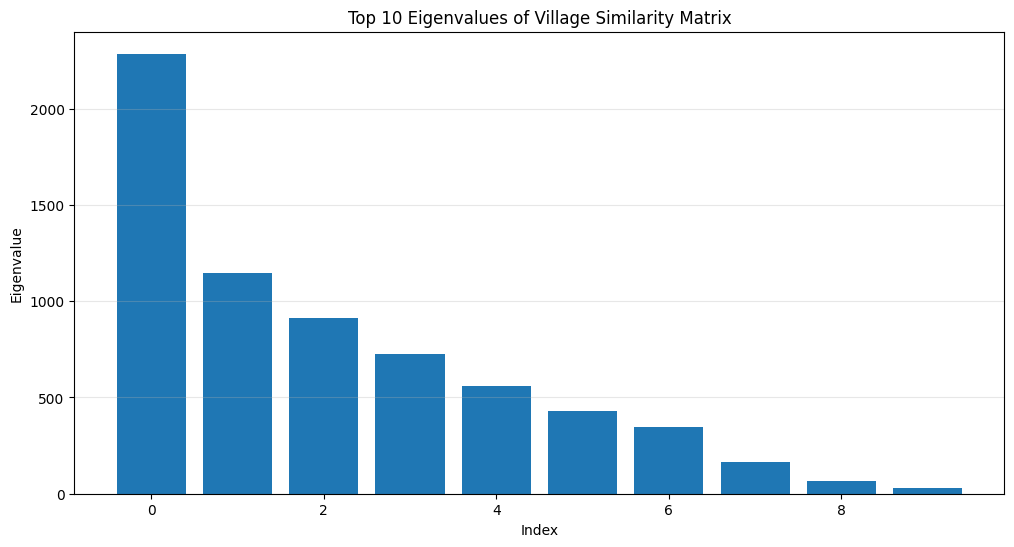

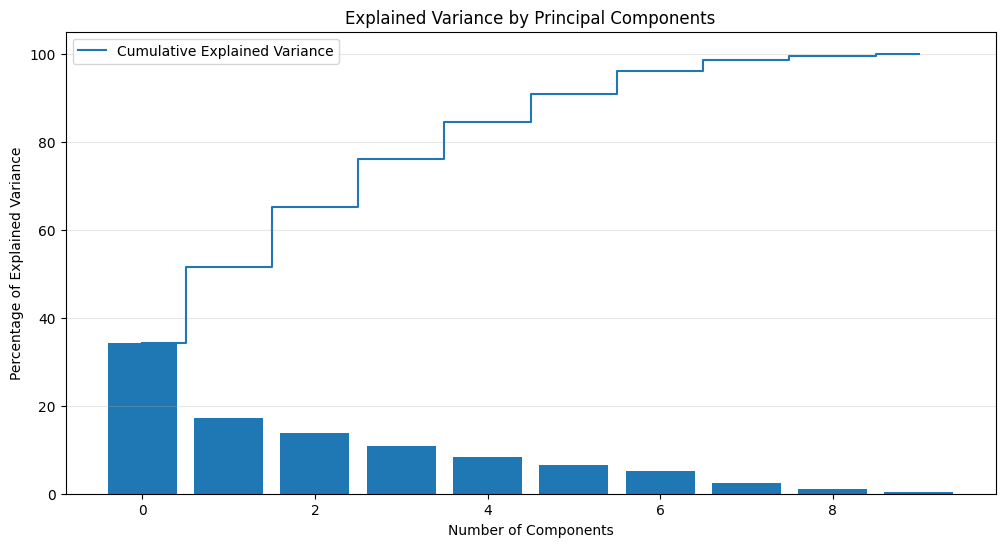

In [5]:
# Perform eigendecomposition on similarity matrix
eigenvalues, eigenvectors = np.linalg.eigh(similarity_matrix)

# Sort eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]  
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Display top eigenvalues
n_top = 10  # Number of top eigenvalues to display
plt.figure(figsize=(12, 6))
plt.bar(range(n_top), eigenvalues[:n_top])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Top 10 Eigenvalues of Village Similarity Matrix')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Calculate percentage of variance explained by each eigenvalue
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the variance explained
plt.figure(figsize=(12, 6))
plt.bar(range(n_top), explained_variance_ratio[:n_top] * 100)
plt.step(range(n_top), cumulative_explained_variance[:n_top] * 100, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

## Create Low-Dimensional Representation of Villages

We'll use the top eigenvectors to create a low-dimensional representation of the villages.

In [6]:
# Choose the number of dimensions to keep (k)
# Select k such that it explains at least 80% of variance
k = np.argmax(cumulative_explained_variance >= 0.8) + 1
print(f"Using {k} dimensions to explain {cumulative_explained_variance[k-1]*100:.2f}% of variance")

# Project villages into the space spanned by the top k eigenvectors
village_embeddings = eigenvectors[:, :k]

# Create a DataFrame to store the embeddings
embeddings_df = pd.DataFrame(village_embeddings)
embeddings_df['cmun'] = pueblos_cmun

# Check the shape of the embedding matrix
print(f"Shape of village embeddings: {village_embeddings.shape}")
display(embeddings_df.head())

Using 5 dimensions to explain 84.46% of variance
Shape of village embeddings: (6670, 5)


,0,1,2,3,4,cmun
0,-0.013889,-0.007832,0.003772,0.016432,0.009651,48067
1,-0.016288,0.008706,-0.002112,-0.016998,0.006286,15064
2,-0.010191,0.009889,0.010702,-0.015351,0.014364,15039
3,-0.004942,-0.004356,0.016319,0.012484,0.003238,48062
4,-0.014498,-0.003746,-0.007882,0.006204,0.009277,48905


## Visualize the Village Embeddings

Let's visualize the embeddings in 2D using t-SNE.

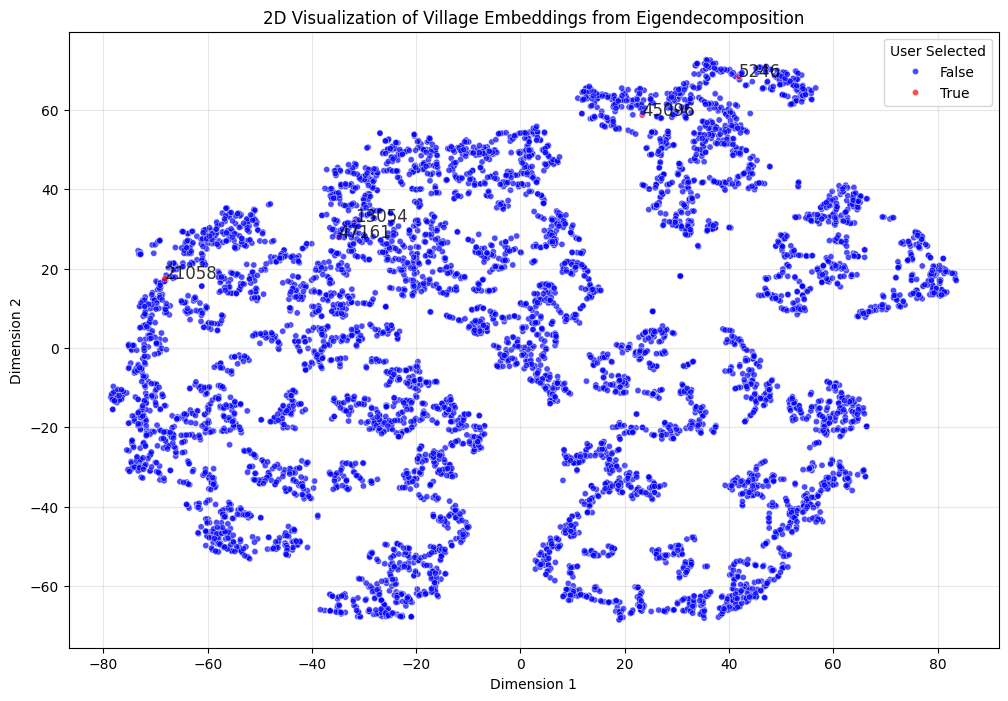

In [7]:
# Use t-SNE to reduce dimensionality for visualization if k > 2
if k > 2:
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(village_embeddings)
else:
    embeddings_2d = village_embeddings

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'cmun': pueblos_cmun
})

# Mark user-selected villages
plot_df['selected'] = plot_df['cmun'].isin(user_choices_cmun)

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='x', y='y', hue='selected', s=20, palette={True: 'red', False: 'blue'}, alpha=0.7)
plt.title('2D Visualization of Village Embeddings from Eigendecomposition')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Label the user-selected villages
for _, row in plot_df[plot_df['selected']].iterrows():
    plt.annotate(str(int(row['cmun'])), (row['x'], row['y']), fontsize=12, alpha=0.8)

plt.legend(title='User Selected', loc='best')
plt.grid(alpha=0.3)
plt.show()

## Calculate Village Recommendations based on Eigenvector Representation

Now we'll use the eigenvector-based representation to recommend villages.

In [8]:
# Get the embeddings of user-selected villages
selected_indices = [cmun_to_index[cmun] for cmun in user_choices_cmun if cmun in cmun_to_index]
selected_embeddings = village_embeddings[selected_indices]

# Calculate centroid of user preferences in eigenvector space
user_centroid = np.mean(selected_embeddings, axis=0)

# Calculate cosine similarity between user centroid and all villages in eigenvector space
similarities = cosine_similarity([user_centroid], village_embeddings)[0]

# Create DataFrame with villages and their similarity scores
results_df = pd.DataFrame({
    'cmun': pueblos_cmun,
    'similarity': similarities
})

# Mark if the village is in the user selected list
results_df['is_selected'] = results_df['cmun'].isin(user_choices_cmun)

# Sort by similarity
sorted_results = results_df.sort_values('similarity', ascending=False)

# Show the top 20 recommended villages
display(sorted_results.head(20))

,cmun,similarity,is_selected
5265,45028,0.985085,False
5745,13083,0.981664,False
5524,45101,0.980802,False
5556,16113,0.971405,False
5488,45135,0.969911,False
6198,30032,0.967935,False
4977,45183,0.966202,False
5051,45056,0.964745,False
5736,13063,0.962686,False
4968,45171,0.955555,False


## Evaluate Recommendation Quality

Let's evaluate the quality of our recommendations using NDCG metric.

In [9]:
def ndcg_at_k(ranked_list, ideal_items, k):
    """Calculate NDCG@k for a list of ranked items."""
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores[:k])])
    
    # Binary relevance: 1 if the item is in ideal_items, 0 otherwise
    ranked_relevance = [1 if item in ideal_items else 0 for item in ranked_list]
    ideal_relevance = sorted(ranked_relevance, reverse=True)
    
    if dcg(ideal_relevance) == 0:
        return 0.0
    
    return dcg(ranked_relevance) / dcg(ideal_relevance)

# Calculate NDCG@10
k = 10
ndcg_score = ndcg_at_k(sorted_results['cmun'].tolist(), user_choices_cmun, k)
print(f"NDCG@{k} score: {ndcg_score:.4f}")

NDCG@10 score: 0.0000


## Visualize Top Recommendations

Let's visualize the top recommendations and compare them with user-selected villages.

/var/folders/w9/bt5d4t050m7fd91t2r7l1mlh0000gn/T/ipykernel_5623/2749476024.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cmun', y='similarity', data=top_recommended, palette='viridis')


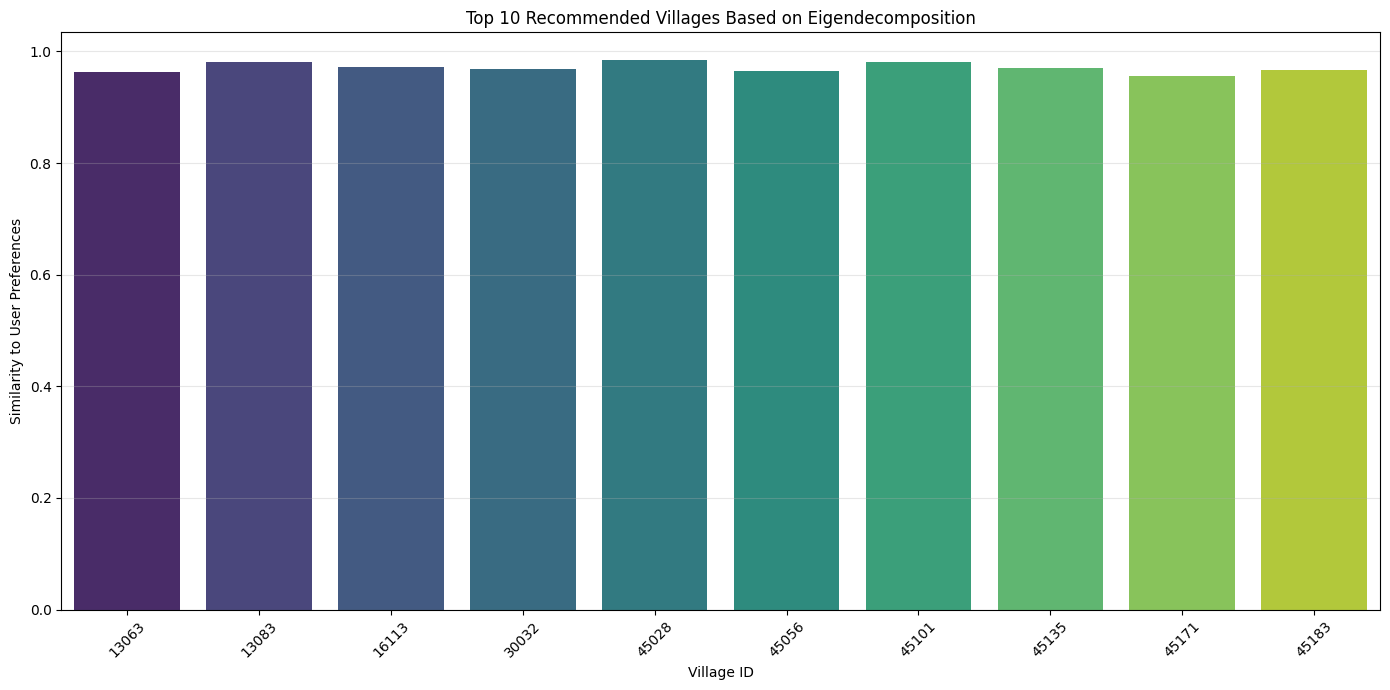

In [10]:
# Get top 10 villages not already selected by user
top_recommended = sorted_results[~sorted_results['is_selected']].head(10)

# Plot the top recommendations
plt.figure(figsize=(14, 7))
sns.barplot(x='cmun', y='similarity', data=top_recommended, palette='viridis')
plt.title('Top 10 Recommended Villages Based on Eigendecomposition')
plt.xlabel('Village ID')
plt.ylabel('Similarity to User Preferences')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Save Model and Results

Let's save our eigenvector model and recommendation results.

In [11]:
# Create directory if it doesn't exist
os.makedirs('../../models', exist_ok=True)

# Save eigendecomposition results
eigen_model = {
    'eigenvalues': eigenvalues,
    'eigenvectors': eigenvectors,
    'village_embeddings': village_embeddings,
    'k': k,
    'cmun_to_index': cmun_to_index,
    'index_to_cmun': index_to_cmun
}

with open('../../models/eigenvector_model.pkl', 'wb') as f:
    pickle.dump(eigen_model, f)

print("Model saved to ../../models/eigenvector_model.pkl")

Model saved to ../../models/eigenvector_model.pkl


## Compare with Node2Vec Results

Let's compare our eigendecomposition recommendations with Node2Vec recommendations.

In [12]:
# Try to load the node2vec model if it exists
try:
    from gensim.models import Word2Vec
    node2vec_model = Word2Vec.load('../../models/node2vec_embeddings.model')
    
    # Get embeddings for user-selected villages
    user_selected_vectors = [node2vec_model.wv[str(v)] for v in user_choices_cmun if str(v) in node2vec_model.wv]
    
    if user_selected_vectors:
        # Calculate user centroid
        node2vec_centroid = np.mean(user_selected_vectors, axis=0)
        
        # Get all village vectors
        all_village_vectors = {v: node2vec_model.wv[str(v)] for v in pueblos_cmun if str(v) in node2vec_model.wv}
        
        # Calculate similarities
        node2vec_similarities = {v: cosine_similarity([node2vec_centroid], [vec])[0][0] for v, vec in all_village_vectors.items()}
        
        # Create dataframe
        node2vec_df = pd.DataFrame({
            'cmun': list(node2vec_similarities.keys()),
            'similarity': list(node2vec_similarities.values())
        })
        
        # Mark user-selected villages
        node2vec_df['is_selected'] = node2vec_df['cmun'].isin(user_choices_cmun)
        
        # Sort by similarity
        node2vec_sorted = node2vec_df.sort_values('similarity', ascending=False)
        
        # Calculate NDCG@10 for Node2Vec
        node2vec_ndcg = ndcg_at_k(node2vec_sorted['cmun'].tolist(), user_choices_cmun, k)
        
        print(f"Node2Vec NDCG@{k} score: {node2vec_ndcg:.4f}")
        print(f"Eigendecomposition NDCG@{k} score: {ndcg_score:.4f}")
        
        # Compare top recommendations
        print("\nTop 10 Node2Vec Recommendations (excluding user selections):")
        display(node2vec_sorted[~node2vec_sorted['is_selected']].head(10))
        
        print("\nTop 10 Eigendecomposition Recommendations (excluding user selections):")
        display(sorted_results[~sorted_results['is_selected']].head(10))
        
        # Get overlap in top 20 recommendations
        top20_node2vec = set(node2vec_sorted[~node2vec_sorted['is_selected']].head(20)['cmun'])
        top20_eigen = set(sorted_results[~sorted_results['is_selected']].head(20)['cmun'])
        overlap = top20_node2vec.intersection(top20_eigen)
        
        print(f"\nOverlap in top 20 recommendations: {len(overlap)} villages")
        print(f"Overlap villages: {sorted(list(overlap))}")
    else:
        print("No user selected villages found in the Node2Vec model vocabulary.")
except Exception as e:
    print(f"Error loading Node2Vec model: {str(e)}")
    print("Run the Node2Vec notebook first to generate the model for comparison.")

Node2Vec NDCG@10 score: 1.0000
Eigendecomposition NDCG@10 score: 0.0000

Top 10 Node2Vec Recommendations (excluding user selections):


,cmun,similarity,is_selected
1045,16187,0.615139,False
1331,29010,0.607622,False
16,31024,0.590616,False
619,49131,0.565670,False
756,37224,0.542117,False
1312,4019,0.537496,False
742,40019,0.535590,False
50,31236,0.509856,False
868,37296,0.508969,False
1032,44210,0.503569,False



Top 10 Eigendecomposition Recommendations (excluding user selections):


,cmun,similarity,is_selected
5265,45028,0.985085,False
5745,13083,0.981664,False
5524,45101,0.980802,False
5556,16113,0.971405,False
5488,45135,0.969911,False
6198,30032,0.967935,False
4977,45183,0.966202,False
5051,45056,0.964745,False
5736,13063,0.962686,False
4968,45171,0.955555,False



Overlap in top 20 recommendations: 0 villages
Overlap villages: []


## Conclusion

We have successfully built a village recommendation system using eigendecomposition of the similarity matrix. This approach has several advantages:

1. It directly captures the inherent structure in the similarity matrix
2. The eigenvector representation is more interpretable, with each component representing a coherent "theme" of village similarity
3. We can choose the exact number of dimensions to represent our data based on explained variance
4. The method is deterministic, unlike some embedding techniques that involve random initialization

The recommendations are based on a reduced dimensionality representation that captures the essential structure of the similarity relationships between villages.